In [7]:
# pip install ipympl
%matplotlib widget
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
%autoreload
from GarbageCollector import MemBalancer
from logparser import get_events_from, LogData, get_log_data_from_folder, get_stats_from_log_data
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
from plotter import plot_gc, plot_membalancer_heap_rule, plot_full_gc_info, plot_benchmark_info
import numpy as np
from os import listdir
from os.path import isfile, join
import scipy.stats as st

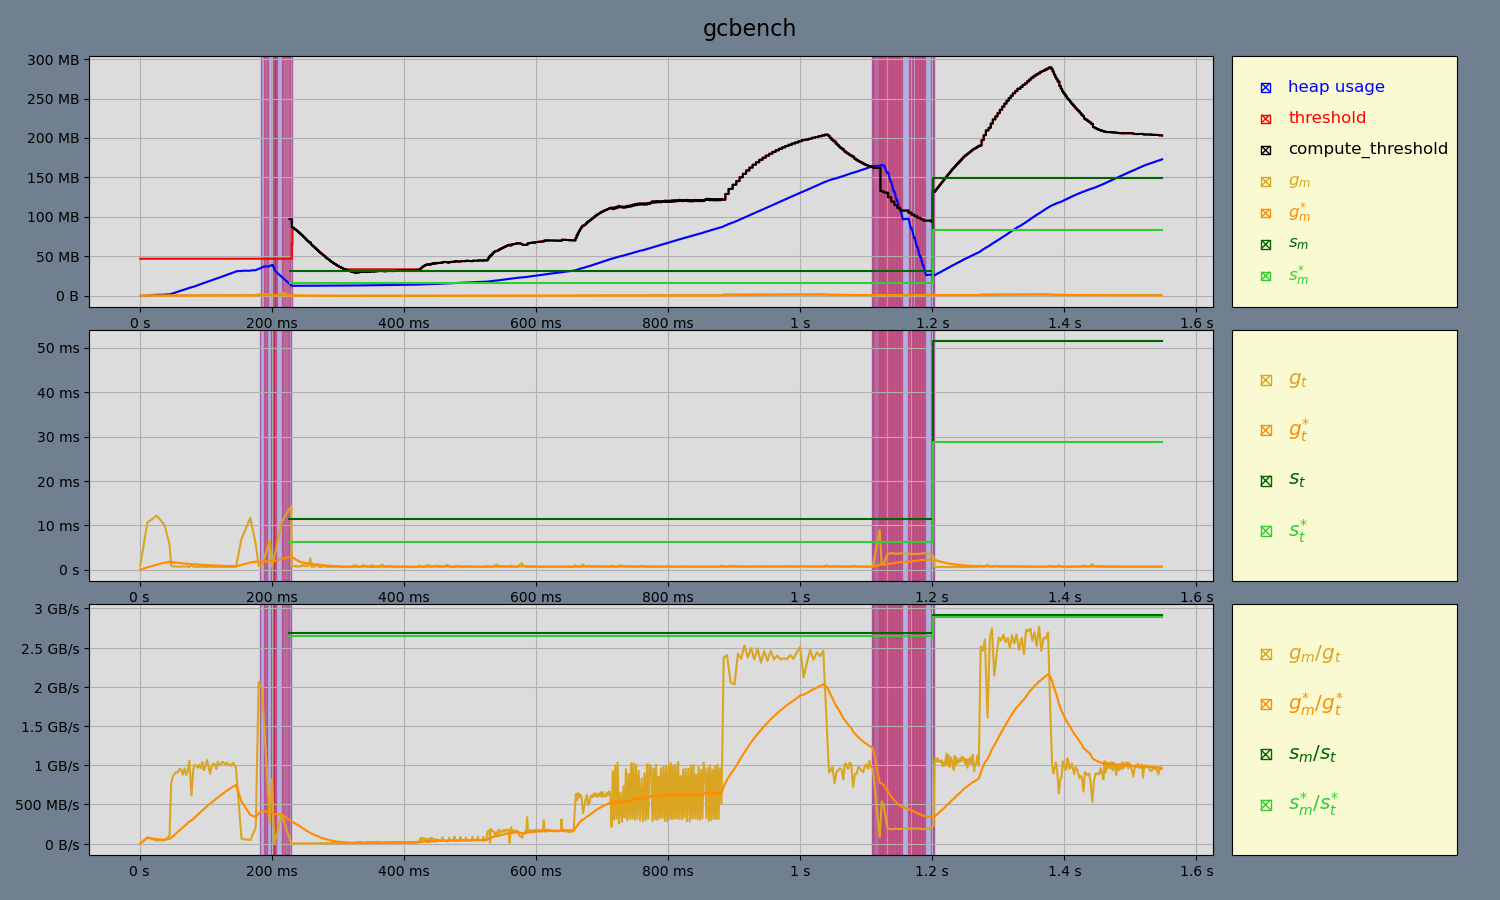

In [114]:
gcbench_data = LogData("logs/gcbench")
s_m_line = plot_full_gc_info(gcbench_data, "gcbench", 3)

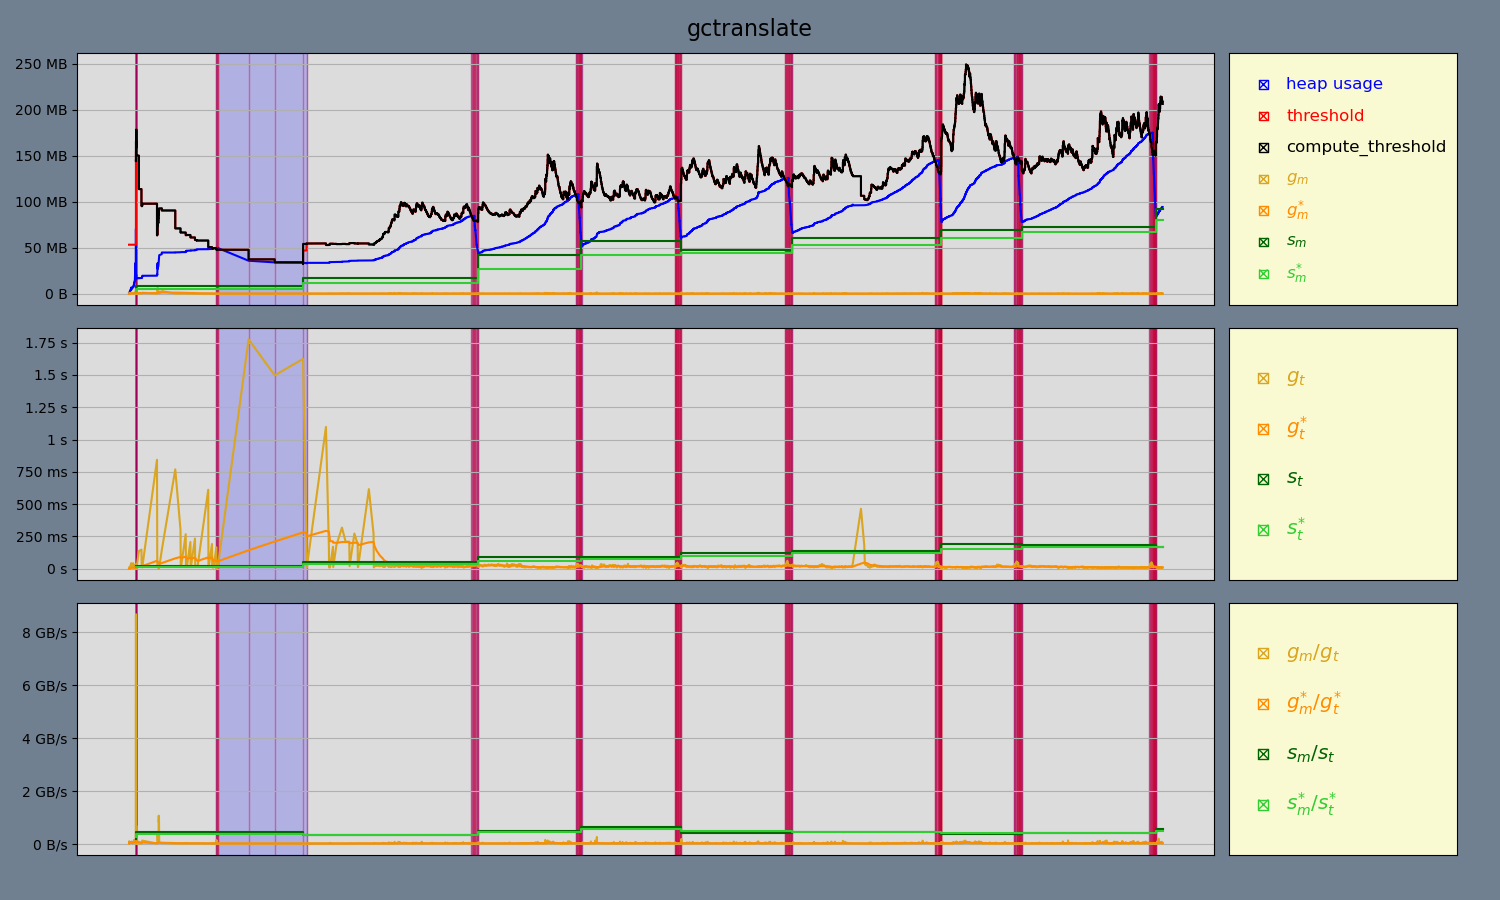

In [34]:
gctranslate_data = LogData("logs/gctranslate")
plot_full_gc_info(gctranslate_data, "gctranslate", 4)

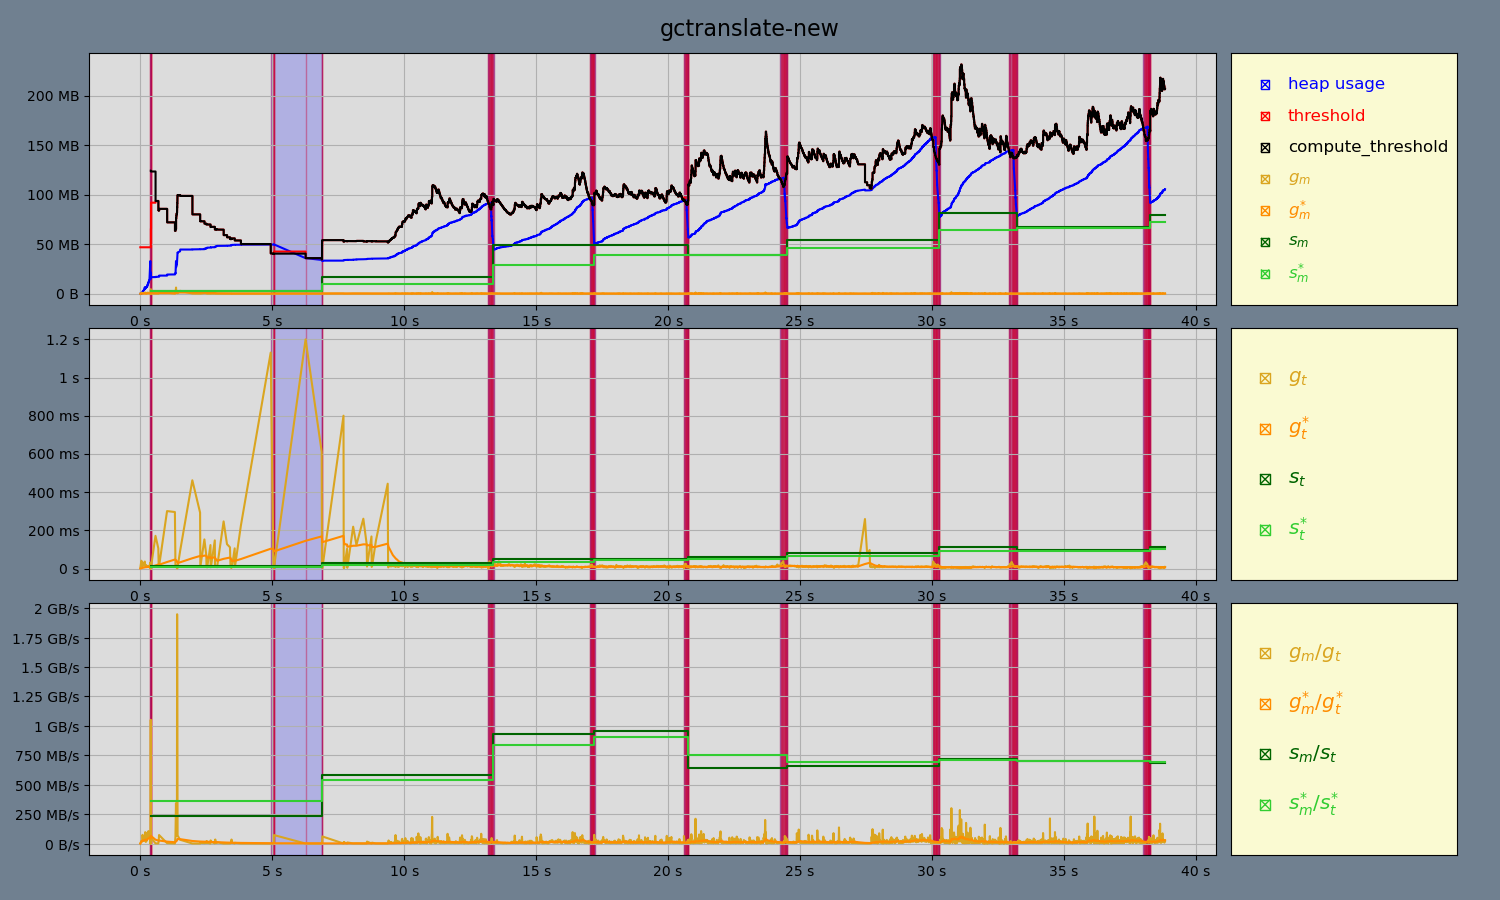

In [32]:
gctranslate2_data = LogData("logs/gctranslate-new")
plot_full_gc_info(gctranslate2_data, "gctranslate-new", 5)

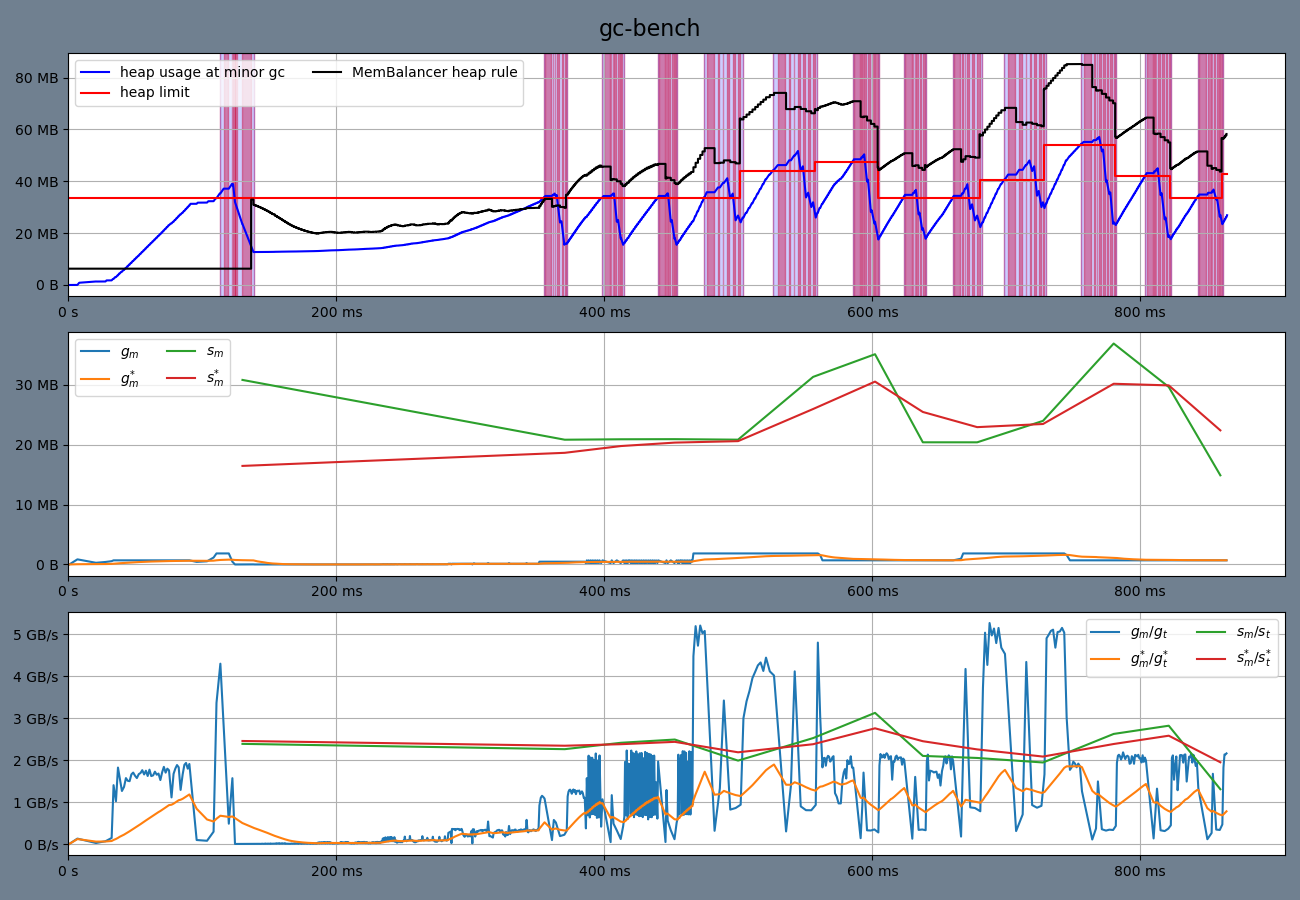

In [31]:
gcbench_events = get_events_from("logs/gcbench-old")
plot_gc(gcbench_events, "gc-bench", fig_num=1)
mem_balancer = MemBalancer(TUNING=1e-8, minimum_extra_heap=2*1024**2)
mem_balancer.L_smoothed = 1024
mem_balancer.s_m_smoothed = 2 * 1024**2
mem_balancer.s_t_smoothed = 1/2024
plot_membalancer_heap_rule(gcbench_events, mem_balancer,fig_num=1)
plt.xlim(left=0)
plt.show()


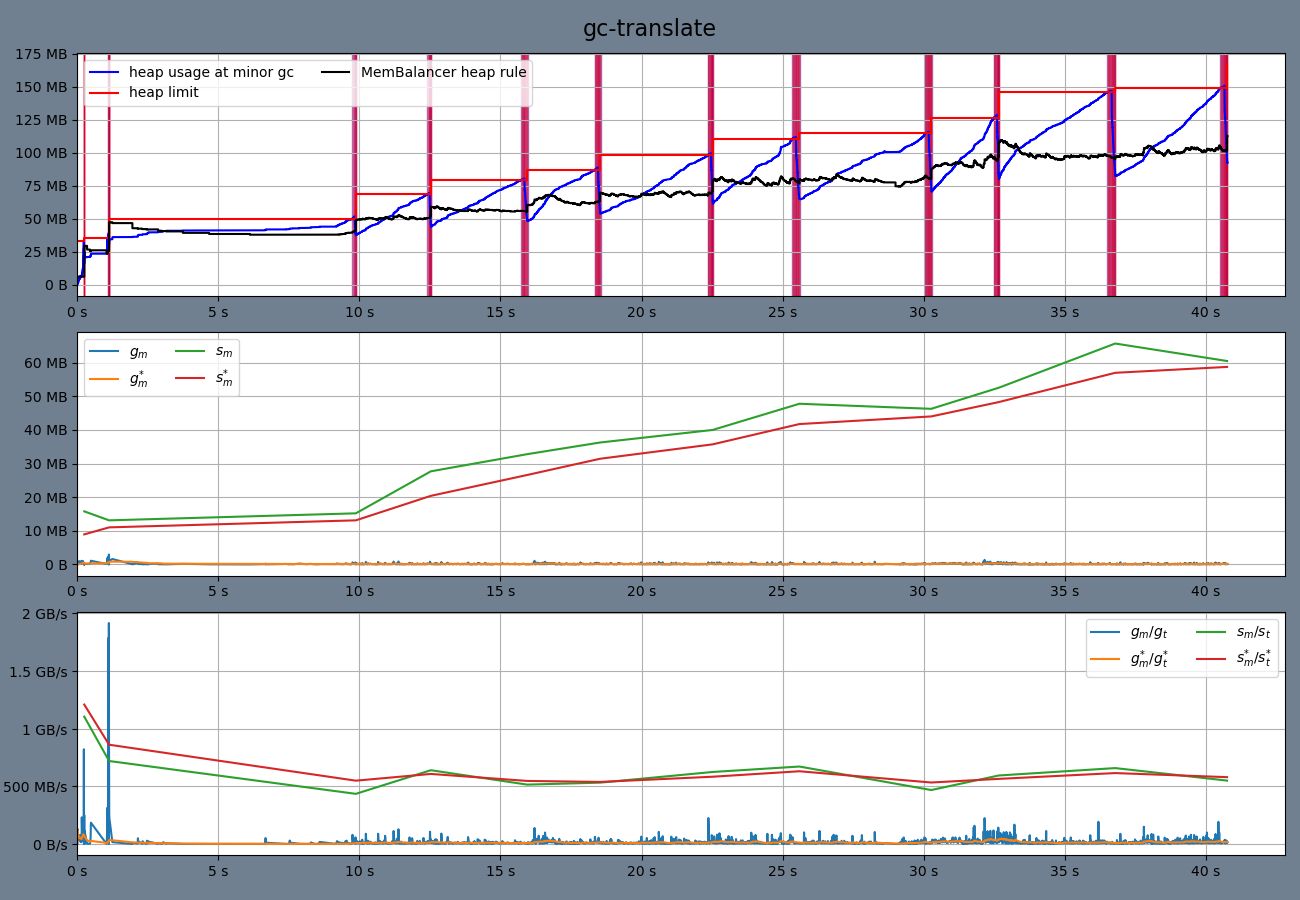

In [30]:
gctranslate_events = get_events_from("logs/gctranslate-old")
plot_gc(gctranslate_events, "gc-translate", fig_num=2)
mem_balancer = MemBalancer(TUNING=1e-8, minimum_extra_heap=2*1024**2)
mem_balancer.L_smoothed = 1024
mem_balancer.s_m_smoothed = 2 * 1024**2
mem_balancer.s_t_smoothed = 1/2024
plot_membalancer_heap_rule(gctranslate_events, mem_balancer, fig_num=2)
plt.xlim(left=0)
plt.show()

In [5]:
def get_tuning_factor(path):
    return float(path.split('/')[-1])

In [14]:
gcbench_benchmark = []
source = "./logs/2024-07-24_14-48-03"
only_folder = [path for file in listdir(
    source) if not isfile(path := join(source, file))]
only_folder.sort(key=get_tuning_factor)
for folder in only_folder:
    gcbench_benchmark.append(get_log_data_from_folder(folder))
gcbench_tuning_factors = [round(get_tuning_factor(path)) for path in only_folder]

20 20


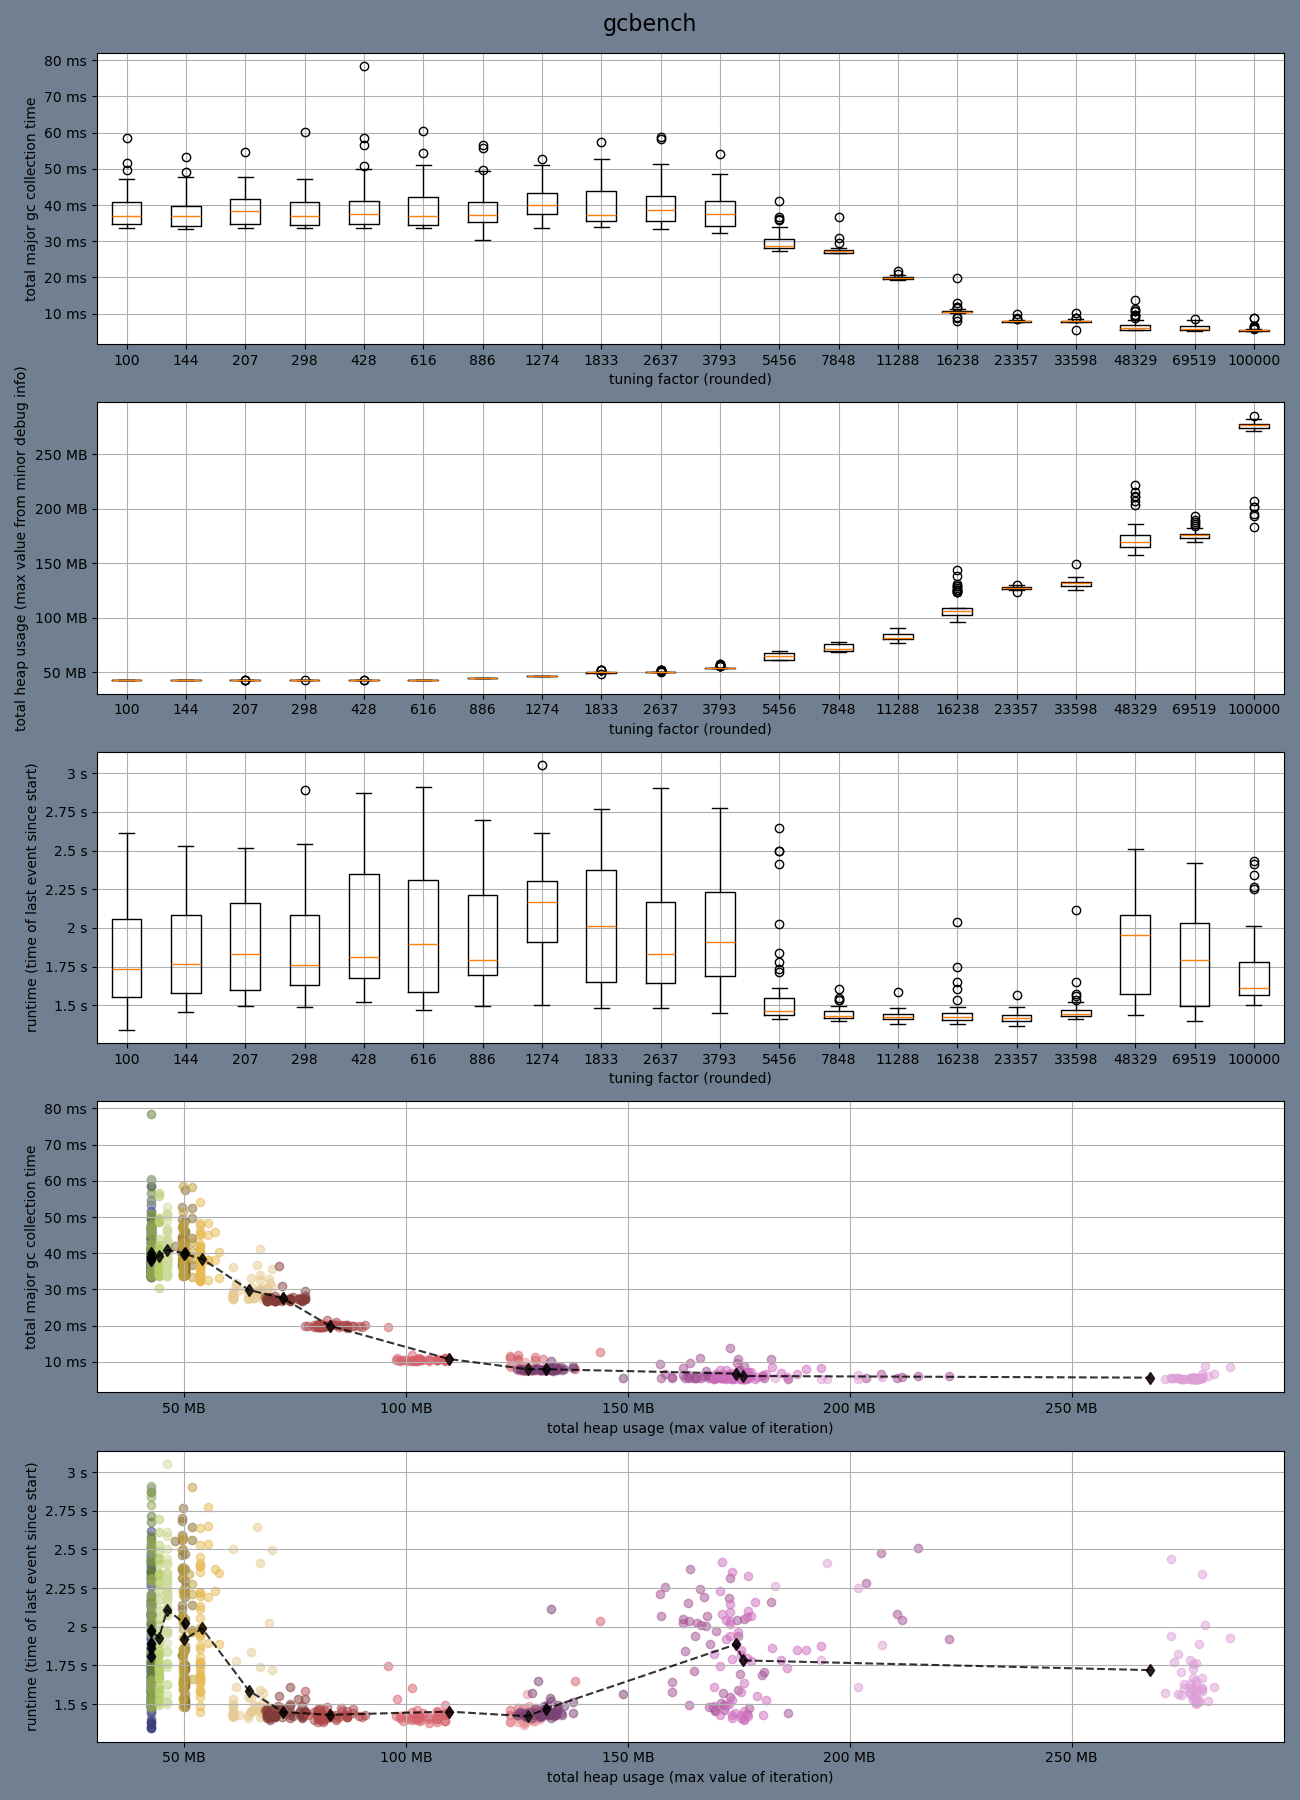

In [15]:
plot_benchmark_info(gcbench_benchmark, gcbench_tuning_factors, 42, title="gcbench")

In [20]:
gctranslate_benchmark = []
source = "../benchmark/gctranslate/2024-07-30_16-03-15/"
only_folder = [path for file in listdir(
    source) if not isfile(path := join(source, file))]
only_folder.sort(key=get_tuning_factor)
for folder in only_folder:
    gctranslate_benchmark.append(get_log_data_from_folder(folder))
gctranslate_tuning_factors = [round(get_tuning_factor(path)) for path in only_folder]

21 21


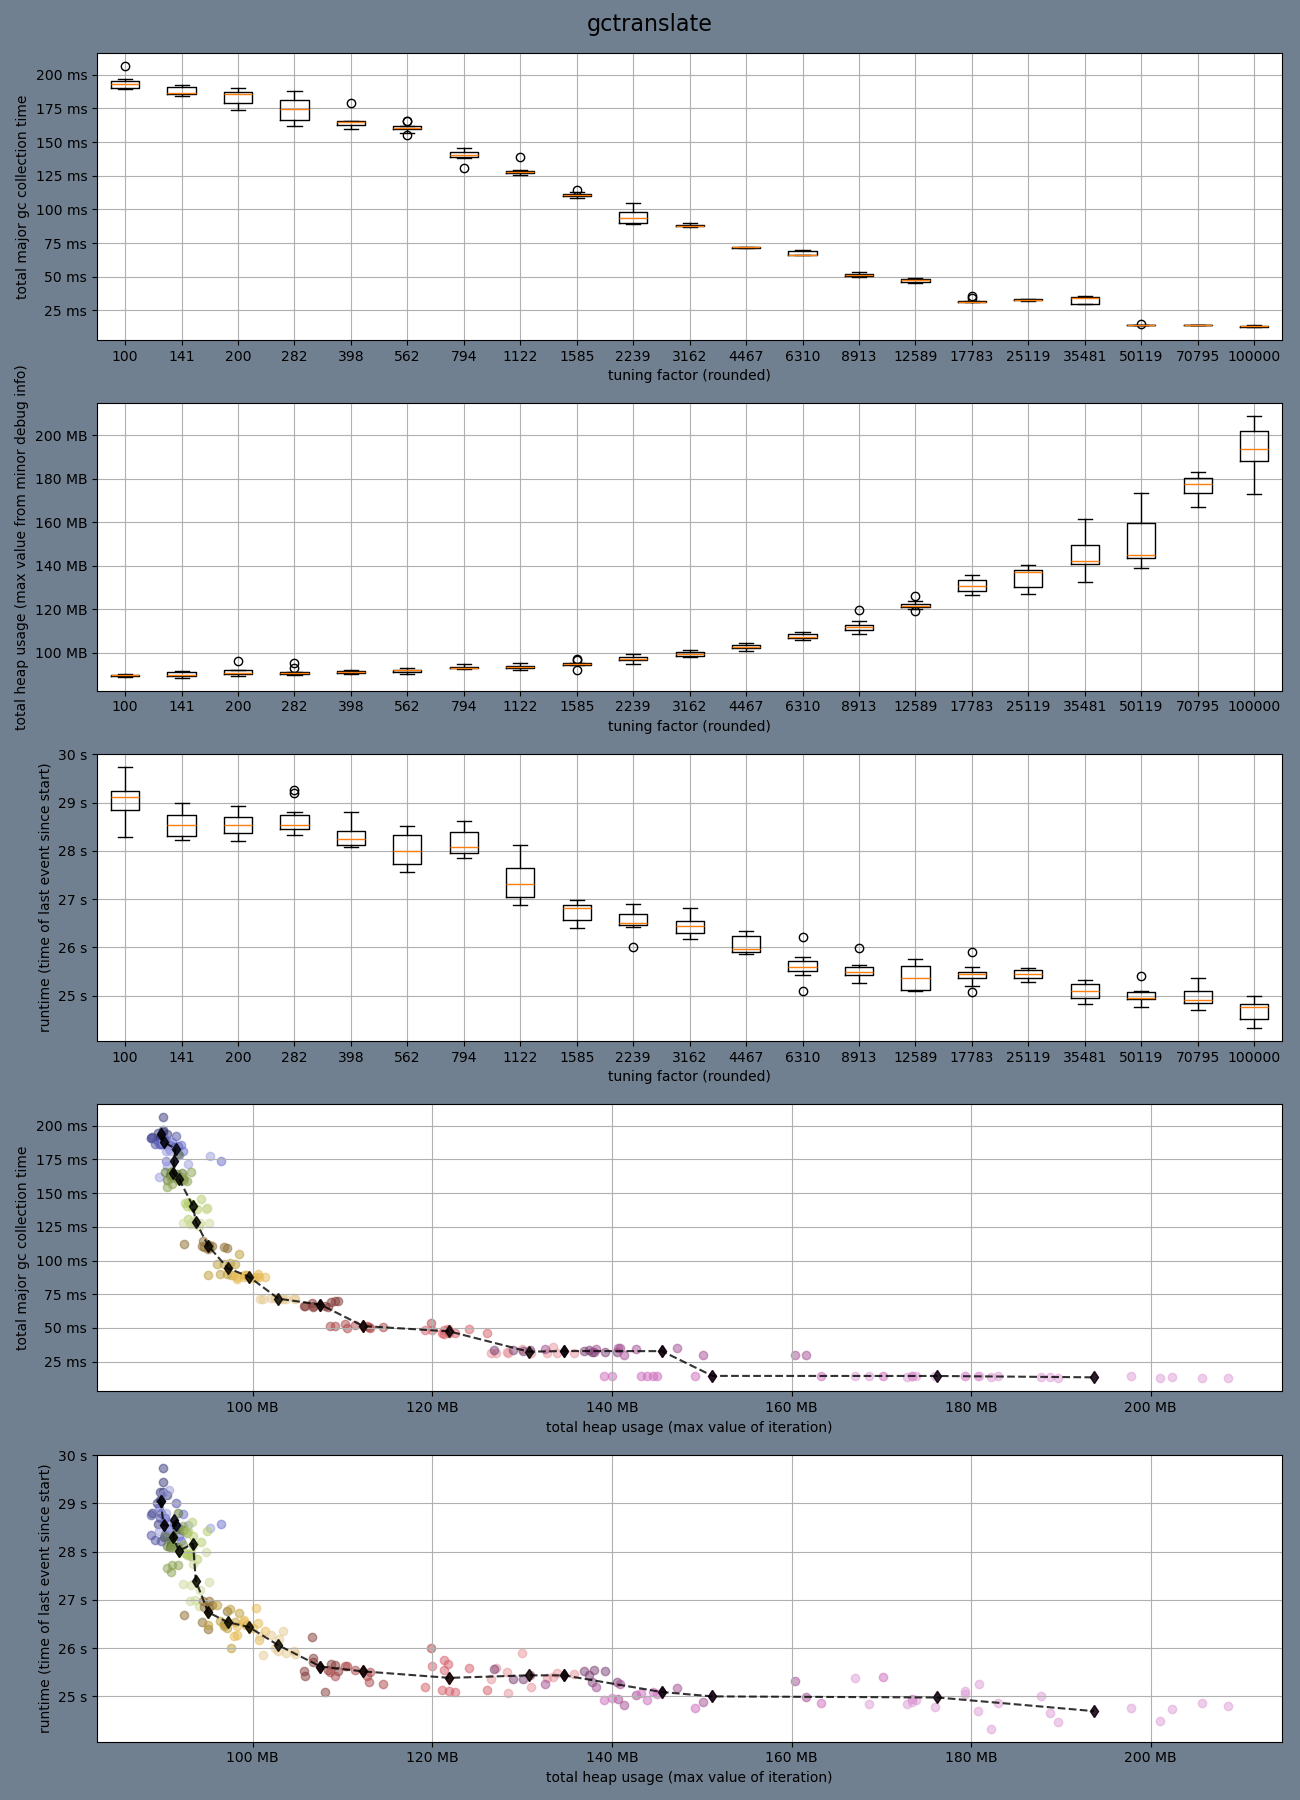

In [21]:
plot_benchmark_info(gctranslate_benchmark, gctranslate_tuning_factors, 43, title="gctranslate")

In [18]:
gcbench_benchmark2 = []
source = "./logs/benchmark/gcbench/2024-08-07_10-31-04/MiniMark"
only_folder = [path for file in listdir(
    source) if not isfile(path := join(source, file))]
only_folder.sort(key=get_tuning_factor)
for folder in only_folder:
    gcbench_benchmark2.append(get_log_data_from_folder(folder, mem_balancer=False))
gcbench_tuning_factors = [round(get_tuning_factor(path),2) for path in only_folder]

['./logs/benchmark/gcbench/2024-08-07_10-31-04/MiniMark/1.4', './logs/benchmark/gcbench/2024-08-07_10-31-04/MiniMark/1.8', './logs/benchmark/gcbench/2024-08-07_10-31-04/MiniMark/2.4', './logs/benchmark/gcbench/2024-08-07_10-31-04/MiniMark/3', './logs/benchmark/gcbench/2024-08-07_10-31-04/MiniMark/3.7', './logs/benchmark/gcbench/2024-08-07_10-31-04/MiniMark/4.4', './logs/benchmark/gcbench/2024-08-07_10-31-04/MiniMark/5.2', './logs/benchmark/gcbench/2024-08-07_10-31-04/MiniMark/6']


8 8


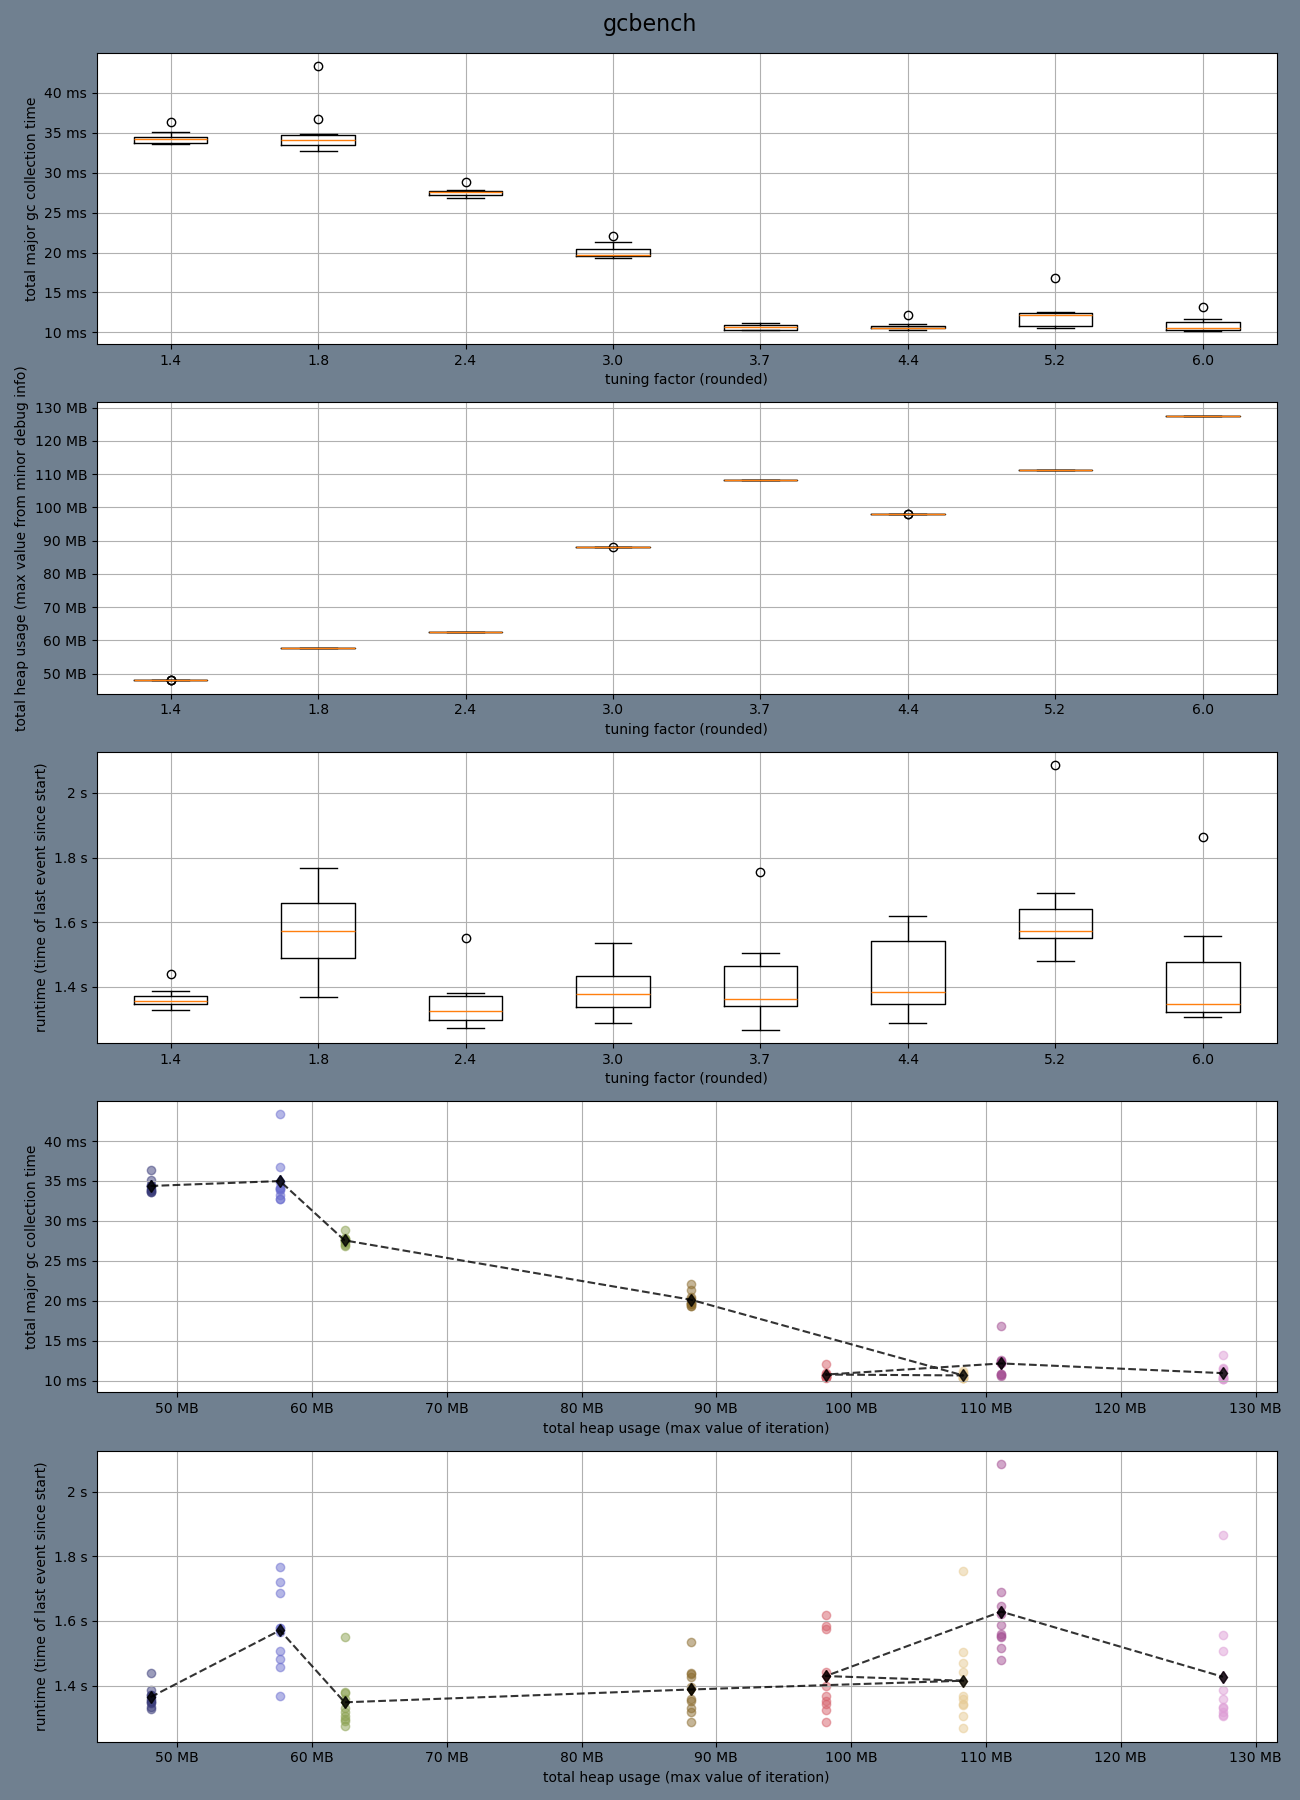

In [19]:
plot_benchmark_info(gcbench_benchmark2, gcbench_tuning_factors, 43, title="gcbench")

In [124]:
nums_of_major_gcs_per_param = [[prog_run.major_gcs for prog_run in bench] for bench in benchmark]
nums_of_minor_gcs_per_param = [[prog_run.minor_gcs for prog_run in bench] for bench in benchmark]
mean_number_of_major_gc = np.mean(nums_of_major_gcs_per_param, axis=1)
median_number_of_major_gc = np.median(nums_of_major_gcs_per_param, axis=1)
print(median_number_of_major_gc, mean_number_of_major_gc)

[16. 16. 16. 16. 16. 16. 16. 16. 15. 14. 13. 11.  9.  7.  5.  4.  4.  3.
  2.  2.] [16.   16.   16.   16.   16.   16.   16.   16.   15.   14.   13.   11.1
  9.    7.    4.8   4.    3.98  2.76  2.    2.  ]


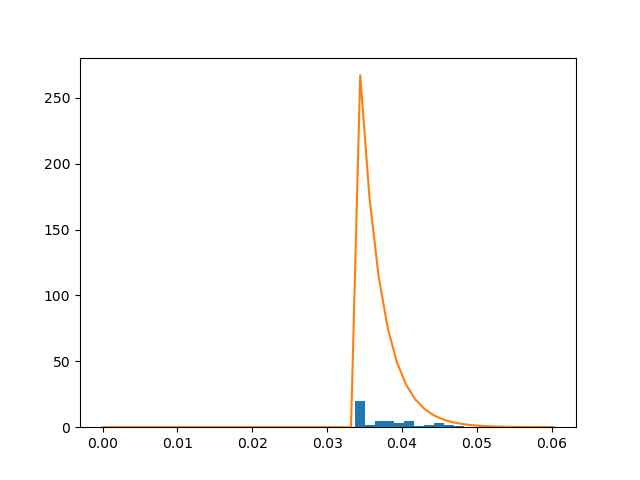

In [125]:
def reject_outliers(data, m=2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s <m]


data = np.array(total_major_gc_time_per_param[3])
b, loc, scale = st.pareto.fit(reject_outliers(data))
plt. figure()
plt.hist(data, bins= 20)
xs = np.linspace(0, max(data))
plt.plot(xs, st.pareto.pdf(xs, b,loc,scale))
plt.show()

In [29]:
frames, avg_frame = get_stats_from_log_data(benchmark, tuning_factors)
display(frames[0], avg_frame)

max heap  total major gc time    runtime
0  89372776.0             0.189380  29.015350
1  90003232.0             0.195741  29.744235
2  90024728.0             0.196993  29.439504
3  90465248.0             0.193880  29.184102
4  90042240.0             0.206397  29.234302
5  89699448.0             0.190252  29.243116
6  89725352.0             0.190704  29.062895
7  90106560.0             0.189313  28.298268
8  88828712.0             0.191660  28.801328
9  89441384.0             0.194377  28.575603

avg max heap  avg runtimes
100       89770968.0     29.059870
141       90086809.6     28.545925
200       91430708.0     28.542880
282       91255764.0     28.656630
398       91149704.0     28.301264
562       91799918.4     28.018984
794       93365416.0     28.166580
1122      93677368.8     27.391496
1585      95057319.2     26.742308
2239      97235038.4     26.537059
3162      99570714.4     26.438884
4467     102878906.4     26.057844
6310     107556157.6     25.617627
8913     112291704.8     25.517430
12589    121906541.6     25.382942
17783    130738502.4     25.434881
25119    134688832.8     25.434454
35481    145576457.6     25.088263
50119    151199484.0     24.998549
70795    176234744.8     24.975935
100000   193688520.0     24.692641